# Tesseract Evaluation - auf Entitäten prüfen

Für das weitere Vorgehe ist es interessant, ob Tesseract, die relevanten Entitäten aus dem Text etxrahiert hat, denn nur diese sind für die weitere Arbeit interessant.
Es ist nicht entscheidend, ob Tesseract alle Textpassagen erkennt, wichtig ist, ob die gewünschten Entitäten erkannt werden.   
Dazu wird in diesem Notebook die Übereinstimmung des OCR-Outputs mit dem gelabelten ground truth überprüft.


---

### OCR-Output auf gewünschte Entitäten prüfen
Der extrahierte Text durch Tesseract OCR wurde in einem CSV gespeichert ( notebook 1).

In [13]:
import pandas as pd

df = pd.read_csv("../../data/OCR/tesseract/OCR_tesseract_simple_psm11.csv")
df.head(1)

,file_name,category,ground_truth,ocr_tesseract,normalized_ocr_tesseract
0,0001.jpg,noisy,SPRACHCAFE WEIHNACHTSFEIER DIENSTAG 21.12. OLO...,*SP\n\nCHCAFE&\n\nWEIR\n\naHTSFELER\n\n\\—h[\n...,*SP CHCAFE& WEIR aHTSFELER \\—h[ \ l U ou1r-mg...


#### 1. auf vorhandene Entitäten prüfen  - Einzelbild

In [15]:
import pandas as pd
import json
from collections import defaultdict

# ---- Parameter ----
file_name = "0001.jpg"
csv_path = "../../data/OCR/tesseract/OCR_tesseract_simple_psm11.csv"
json_path = "../../data/data_annotated.json"

# ---- Daten laden ----
# CSV einlesen
df = pd.read_csv(csv_path)
df["normalized_ocr_tesseract"] = df["normalized_ocr_tesseract"].astype(str)

# JSON einlesen
with open(json_path, "r", encoding="utf-8") as f:
    json_data = json.load(f)

# ---- Entsprechenden JSON-Eintrag finden ----
entry = next((item for item in json_data if item["file_name"] == file_name), None)
if entry is None:
    print(f"Kein Eintrag für {file_name} in der JSON-Datei gefunden.")
else:
    ocr_row = df[df["file_name"] == file_name]
    if ocr_row.empty:
        print(f"Kein OCR-Text für {file_name} in der CSV gefunden.")
    else:
        ocr_text = ocr_row["normalized_ocr_tesseract"].values[0]
        print(f"OCR-Text:\n{ocr_text}\n")

        found = defaultdict(list)
        missing = defaultdict(list)

        for ent in entry["entities"]:
            label = ent["label"]
            value = ent["text"].strip()
            if value in ocr_text:
                found[label].append(value)
            else:
                missing[label].append(value)

        print(f"Ergebnis für {file_name}:\n")
        print("Gefundene Entitäten:")
        for typ in sorted(found):
            print(f"  {typ}: {found[typ]}")
        print("\nFehlende Entitäten:")
        for typ in sorted(missing):
            print(f"  {typ}: {missing[typ]}")


OCR-Text:
*SP CHCAFE& WEIR aHTSFELER \\—h[ \ l U ou1r-mgvu ZENTRUM — WIR FREUEN UNS AUF EUCH!

Ergebnis für 0001.jpg:

Gefundene Entitäten:

Fehlende Entitäten:
  DATE: ['DIENSTAG', '21.12.']
  EVENT: ['WEIHNACHTSFEIER']
  LOC: ['SPRACHCAFE', 'OLOF-PALME ZENTRUM']
  TIME: ['19 UHR']


#### 2. auf vorhandene Entitäten prüfen - ganzer Datensatz

In [7]:
import json
import pandas as pd

JSON_PATH = "../../data/data_annotated.json"
CSV_PATH = "../../data/OCR/tesseract/OCR_tesseract_simple_psm11.csv"
OUTPUT_PATH = "../../data/OCR/tesseract_results_entity_psm11.csv"

# JSON & CSV laden
with open(JSON_PATH, "r", encoding="utf-8") as f:
    gt_data = json.load(f)

ocr_df = pd.read_csv(CSV_PATH)

# NAN Werte mit leerem String ersetzen, sonst gibt es Fehler
ocr_df["normalized_ocr_tesseract"] = ocr_df["normalized_ocr_tesseract"].fillna("")


labels = ["EVENT", "TOPIC", "DATE", "TIME", "LOC"]


results = []

for gt_entry in gt_data:
    file_name = gt_entry["file_name"]
    gt_entities = gt_entry.get("entities", [])

    # OCR-Text 
    ocr_row = ocr_df[ocr_df["file_name"] == file_name]
    if ocr_row.empty:
        print(f"OCR-Text für {file_name} nicht gefunden – übersprungen.")
        continue
    ocr_text = ocr_row.iloc[0]["normalized_ocr_tesseract"] # holt aus erster zeile( gibt nur eine) text aus spalte "normalized_ocr_tesseract"

    # Initiale Zähler
    result_row = {"file_name": file_name}
    for label in labels:
        result_row[f"Anzahl_{label}_gt"] = 0
        result_row[f"Anzahl_{label}_erkannt"] = 0

    erkannte_entitaeten = []
    nicht_erkannte_entitaeten = []

    for ent in gt_entities:
        label = ent["label"]
        text = ent["text"]

        if label not in labels:
            continue

        # Ground-Truth-Zähler erhöhen
        result_row[f"Anzahl_{label}_gt"] += 1

        # Prüfen, ob Text im OCR vorkommt
        if text in ocr_text:
            result_row[f"Anzahl_{label}_erkannt"] += 1
            erkannte_entitaeten.append(f"[{label}] {text}")
        else:
            nicht_erkannte_entitaeten.append(f"[{label}] {text}")

    # Listen speichern als Strings
    result_row["erkannte_entities"] = "; ".join(erkannte_entitaeten)
    result_row["nicht_erkannte_entities"] = "; ".join(nicht_erkannte_entitaeten)

    results.append(result_row)

# In DataFrame umwandeln und speichern
df_result = pd.DataFrame(results)
df_result.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")

print(f"Auswertung gespeichert in: {OUTPUT_PATH}")

Auswertung gespeichert in: ../../data/OCR/tesseract_results_entity_psm11.csv


In [8]:
df = pd.read_csv("../../data/OCR/tesseract_results_entity_psm11.csv")
df.head()

,file_name,Anzahl_EVENT_gt,Anzahl_EVENT_erkannt,Anzahl_TOPIC_gt,Anzahl_TOPIC_erkannt,Anzahl_DATE_gt,Anzahl_DATE_erkannt,Anzahl_TIME_gt,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities
0,0001.jpg,1,0,0,0,2,0,1,0,2,0,NaN,[EVENT] WEIHNACHTSFEIER; [DATE] DIENSTAG; [DAT...
1,0002.jpg,1,0,1,1,1,1,1,1,2,0,[TOPIC] SOLIDARITÄT MIT ALLEN!; [DATE] 8.8.; [...,[EVENT] KUNDGEBUNG; [LOC] Dresden; [LOC] Große...
2,0003.jpg,2,2,1,1,1,0,1,1,3,3,[EVENT] Gedenkkundgebung; [EVENT] Demonstratio...,[DATE] 9. November 1938–2023
3,0004.jpg,1,1,0,0,2,0,1,0,2,0,[EVENT] FEIERABEND SINGEN,[DATE] MITTWOCH; [DATE] 21. JUNI 2023; [TIME] ...
4,0006.jpg,1,1,1,0,1,0,1,0,0,0,[EVENT] DEMO,[TOPIC] GEGEN GENTRIFIZIERUNG; [DATE] 09. JULI...


#### Entitäten Erkennungsrate berechnen

In [10]:
import pandas as pd


def berechne_erkennungsraten(csv_datei):
    # CSV laden
    df = pd.read_csv(csv_datei)

    # Entitäten, für die Erkennungsraten berechnet werden sollen
    entities = ["EVENT", "TOPIC", "DATE", "TIME", "LOC"]

    # Für jede Entität die Erkennungsrate berechnen
    for ent in entities:
        gt_col = f"Anzahl_{ent}_gt"
        erk_col = f"Anzahl_{ent}_erkannt"
        rate_col = f"Erkennungsrate_{ent}"

        # Division mit Schutz vor 0
        df[rate_col] = df[erk_col] / df[gt_col]
        df[rate_col] = df[rate_col].replace([float("inf"), float("-inf")], 0).fillna(0)

    return df


In [11]:
CSV_PATH = "../../data/OCR/tesseract_results_entity_psm11.csv"

df_ergebnisse = berechne_erkennungsraten(CSV_PATH)

df_ergebnisse.head()
#print(df_ergebnisse[["file_name", "Erkennungsrate_EVENT", "Erkennungsrate_TOPIC", 
 #                    "Erkennungsrate_DATE", "Erkennungsrate_TIME", "Erkennungsrate_LOC"]])


,file_name,Anzahl_EVENT_gt,Anzahl_EVENT_erkannt,Anzahl_TOPIC_gt,Anzahl_TOPIC_erkannt,Anzahl_DATE_gt,Anzahl_DATE_erkannt,Anzahl_TIME_gt,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities,Erkennungsrate_EVENT,Erkennungsrate_TOPIC,Erkennungsrate_DATE,Erkennungsrate_TIME,Erkennungsrate_LOC
0,0001.jpg,1,0,0,0,2,0,1,0,2,0,NaN,[EVENT] WEIHNACHTSFEIER; [DATE] DIENSTAG; [DAT...,0.0,0.0,0.0,0.0,0.0
1,0002.jpg,1,0,1,1,1,1,1,1,2,0,[TOPIC] SOLIDARITÄT MIT ALLEN!; [DATE] 8.8.; [...,[EVENT] KUNDGEBUNG; [LOC] Dresden; [LOC] Große...,0.0,1.0,1.0,1.0,0.0
2,0003.jpg,2,2,1,1,1,0,1,1,3,3,[EVENT] Gedenkkundgebung; [EVENT] Demonstratio...,[DATE] 9. November 1938–2023,1.0,1.0,0.0,1.0,1.0
3,0004.jpg,1,1,0,0,2,0,1,0,2,0,[EVENT] FEIERABEND SINGEN,[DATE] MITTWOCH; [DATE] 21. JUNI 2023; [TIME] ...,1.0,0.0,0.0,0.0,0.0
4,0006.jpg,1,1,1,0,1,0,1,0,0,0,[EVENT] DEMO,[TOPIC] GEGEN GENTRIFIZIERUNG; [DATE] 09. JULI...,1.0,0.0,0.0,0.0,0.0


In [12]:
mean_reg_rate_Event = df_ergebnisse["Erkennungsrate_EVENT"].mean()
mean_reg_rate_Topic = df_ergebnisse["Erkennungsrate_TOPIC"].mean()
mean_reg_rate_Date = df_ergebnisse["Erkennungsrate_DATE"].mean()
mean_reg_rate_Time = df_ergebnisse["Erkennungsrate_TIME"].mean()
mean_reg_rate_Loc = df_ergebnisse["Erkennungsrate_LOC"].mean()

reg_rate_ALL = (mean_reg_rate_Event + mean_reg_rate_Topic + mean_reg_rate_Date + mean_reg_rate_Time + mean_reg_rate_Loc) / 5


print(f"Erkennungsrate gesamt: {reg_rate_ALL:.3f}")
print(f"Erkennungsrate pro Entität:")
print(f"Event: {mean_reg_rate_Event:.3f}")
print(f"Topic: {mean_reg_rate_Topic:.3f}")
print(f"Date: {mean_reg_rate_Date:.3f}")
print(f"Time: {mean_reg_rate_Time:.3f}")
print(f"Loc: {mean_reg_rate_Loc:.3f}")



Erkennungsrate gesamt: 0.371
Erkennungsrate pro Entität:
Event: 0.383
Topic: 0.205
Date: 0.440
Time: 0.392
Loc: 0.438


psm 3:  
Erkennungsrate gesamt: 0.383  
Erkennungsrate pro Entität:  
Event: 0.379  
Topic: 0.220  
Date: 0.455  
Time: 0.413  
Loc: 0.448  

#### für weitere Analysen csv Dateien mergen

In [16]:
df = pd.read_csv("../../data/OCR/tesseract/OCR_tesseract_simple_psm11.csv")

In [17]:
df.head(1)

,file_name,category,ground_truth,ocr_tesseract,normalized_ocr_tesseract
0,0001.jpg,noisy,SPRACHCAFE WEIHNACHTSFEIER DIENSTAG 21.12. OLO...,*SP\n\nCHCAFE&\n\nWEIR\n\naHTSFELER\n\n\\—h[\n...,*SP CHCAFE& WEIR aHTSFELER \\—h[ \ l U ou1r-mg...


In [18]:
df_reduced = df[["file_name", "category"]]

# Join über name und file_name
merged = pd.merge(df_reduced, df_ergebnisse, on="file_name", how="left")

merged.head()


,file_name,category,Anzahl_EVENT_gt,Anzahl_EVENT_erkannt,Anzahl_TOPIC_gt,Anzahl_TOPIC_erkannt,Anzahl_DATE_gt,Anzahl_DATE_erkannt,Anzahl_TIME_gt,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities,Erkennungsrate_EVENT,Erkennungsrate_TOPIC,Erkennungsrate_DATE,Erkennungsrate_TIME,Erkennungsrate_LOC
0,0001.jpg,noisy,1,0,0,0,2,0,1,0,2,0,NaN,[EVENT] WEIHNACHTSFEIER; [DATE] DIENSTAG; [DAT...,0.0,0.0,0.0,0.0,0.0
1,0002.jpg,noisy,1,0,1,1,1,1,1,1,2,0,[TOPIC] SOLIDARITÄT MIT ALLEN!; [DATE] 8.8.; [...,[EVENT] KUNDGEBUNG; [LOC] Dresden; [LOC] Große...,0.0,1.0,1.0,1.0,0.0
2,0003.jpg,noisy,2,2,1,1,1,0,1,1,3,3,[EVENT] Gedenkkundgebung; [EVENT] Demonstratio...,[DATE] 9. November 1938–2023,1.0,1.0,0.0,1.0,1.0
3,0004.jpg,noisy,1,1,0,0,2,0,1,0,2,0,[EVENT] FEIERABEND SINGEN,[DATE] MITTWOCH; [DATE] 21. JUNI 2023; [TIME] ...,1.0,0.0,0.0,0.0,0.0
4,0006.jpg,noisy,1,1,1,0,1,0,1,0,0,0,[EVENT] DEMO,[TOPIC] GEGEN GENTRIFIZIERUNG; [DATE] 09. JULI...,1.0,0.0,0.0,0.0,0.0


In [19]:
avg_reg_rate_EVENT_per_category = merged.groupby("category")["Erkennungsrate_EVENT"].mean() 
print((avg_reg_rate_EVENT_per_category).sort_values(ascending=False))

category
simple    0.525641
noisy     0.455556
fancy     0.353395
photo     0.200000
skewed    0.182796
Name: Erkennungsrate_EVENT, dtype: float64


In [20]:
avg_reg_rate_TOPIC_per_category = merged.groupby("category")["Erkennungsrate_TOPIC"].mean() 
print((avg_reg_rate_TOPIC_per_category).sort_values(ascending=False))

category
simple    0.420513
noisy     0.177778
fancy     0.094136
skewed    0.075269
photo     0.041667
Name: Erkennungsrate_TOPIC, dtype: float64


In [21]:
avg_reg_rate_DATE_per_category = merged.groupby("category")["Erkennungsrate_DATE"].mean() 
print((avg_reg_rate_DATE_per_category).sort_values(ascending=False))

category
simple    0.653846
photo     0.383333
skewed    0.368280
fancy     0.345679
noisy     0.255556
Name: Erkennungsrate_DATE, dtype: float64


In [22]:
avg_reg_rate_TIME_per_category = merged.groupby("category")["Erkennungsrate_TIME"].mean() 
print((avg_reg_rate_TIME_per_category).sort_values(ascending=False))

category
simple    0.569231
noisy     0.372222
skewed    0.301075
fancy     0.283951
photo     0.275000
Name: Erkennungsrate_TIME, dtype: float64


In [23]:
avg_reg_rate_LOC_per_category = merged.groupby("category")["Erkennungsrate_LOC"].mean() 
print((avg_reg_rate_LOC_per_category).sort_values(ascending=False))

category
simple    0.631282
fancy     0.385802
noisy     0.372222
skewed    0.311828
photo     0.250000
Name: Erkennungsrate_LOC, dtype: float64


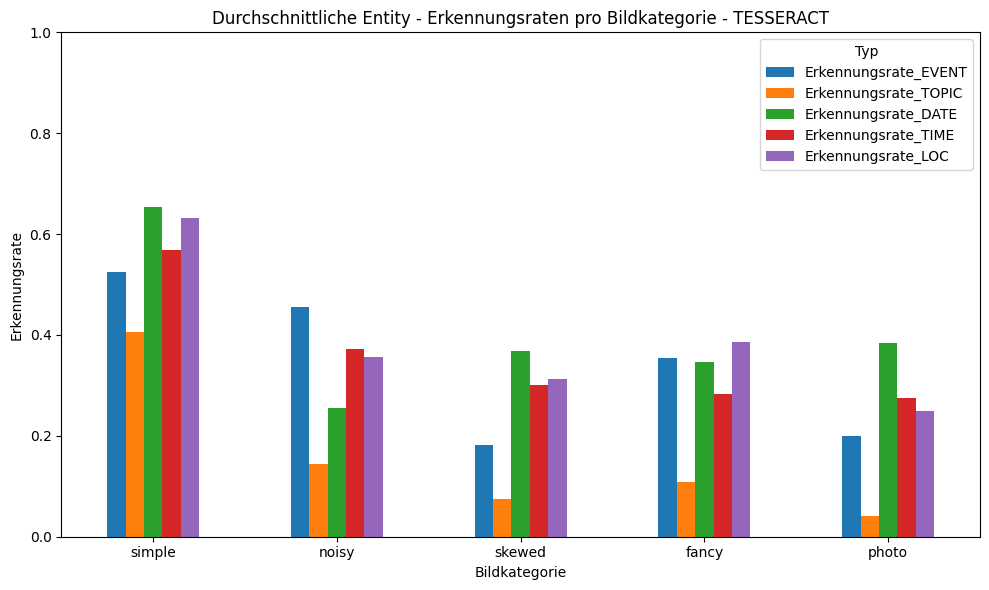

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Mittelwerte berechnen
avg_event = merged.groupby("category")["Erkennungsrate_EVENT"].mean()
avg_topic = merged.groupby("category")["Erkennungsrate_TOPIC"].mean()
avg_date = merged.groupby("category")["Erkennungsrate_DATE"].mean()
avg_time = merged.groupby("category")["Erkennungsrate_TIME"].mean()
avg_loc = merged.groupby("category")["Erkennungsrate_LOC"].mean()

# Zusammenführen zu einem DataFrame
df_combined = pd.DataFrame({
    "Erkennungsrate_EVENT": avg_event,
    "Erkennungsrate_TOPIC": avg_topic,
    "Erkennungsrate_DATE": avg_date,
    "Erkennungsrate_TIME": avg_time,
    "Erkennungsrate_LOC": avg_loc
})

# Eigene Reihenfolge definieren
category_order = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
df_combined = df_combined.loc[category_order]


# Plot
ax = df_combined.plot(kind="bar", figsize=(10, 6))
plt.title("Durchschnittliche Entity - Erkennungsraten pro Bildkategorie - TESSERACT")
plt.ylabel("Erkennungsrate")
plt.xlabel("Bildkategorie")
plt.xticks(rotation=0)
plt.legend(title="Typ")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [24]:
merged.to_csv("../../data/OCR/tesseract/tesseract_results_entity_psm11.csv", index=False)

---
#### Korrelation zwischen Entity Erkennungsrate und CER / WER?

In [27]:
df = pd.read_csv("../../data/OCR/tesseract/tesseract_results_linewise_psm11.csv")

In [28]:
df.head()

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,ocr_tesseract_psm11,category,ground_truth,recognition_rate
0,0001.jpg,6,10,1,0.833333,0.833333,0.166667,0.166667,"['*SP', 'CHCAFE&', 'WEIR', 'aHTSFELER', '\\\\—...",noisy,SPRACHCAFE WEIHNACHTSFEIER DIENSTAG 21.12. OLO...,0.166667
1,0002.jpg,7,35,3,0.597744,0.653061,0.397321,0.346939,"['D D', '3', '@', 'STA', 'N', '„', 'XM', 'S', ...",noisy,SCHLIESST EUCH AN! ET Video & Content nichtohn...,0.428571
2,0003.jpg,11,20,6,0.491259,0.500000,0.510204,0.454545,"['Gedenkkundgebung und', 'antifaschistische De...",noisy,»ES IST GESCHEHEN UND FOLGLICH KANN ES WIEDER ...,0.545455
3,0004.jpg,11,7,2,0.818182,0.818182,0.181818,0.181818,"['FEIERABEND', 'SINGEN', 'f', '\\', 'X', 'M JE...",noisy,FEIERABEND SINGEN KULTUR NETZ Meiendorf IMMER ...,0.181818
4,0006.jpg,8,21,1,0.913462,0.916667,0.083333,0.083333,"[""x .I.I.V '( ].E—‘j"", 'aa“', 'll', '|‘l?-;l',...",noisy,IHR HABT UNS DIE STADT GESTOHLEN GEBT SIE WIED...,0.125000


In [29]:

new_df = df.merge(merged, how="left")

new_df.head()

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,ocr_tesseract_psm11,category,...,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities,Erkennungsrate_EVENT,Erkennungsrate_TOPIC,Erkennungsrate_DATE,Erkennungsrate_TIME,Erkennungsrate_LOC
0,0001.jpg,6,10,1,0.833333,0.833333,0.166667,0.166667,"['*SP', 'CHCAFE&', 'WEIR', 'aHTSFELER', '\\\\—...",noisy,...,0,2,0,NaN,[EVENT] WEIHNACHTSFEIER; [DATE] DIENSTAG; [DAT...,0.0,0.0,0.0,0.0,0.0
1,0002.jpg,7,35,3,0.597744,0.653061,0.397321,0.346939,"['D D', '3', '@', 'STA', 'N', '„', 'XM', 'S', ...",noisy,...,1,2,0,[TOPIC] SOLIDARITÄT MIT ALLEN!; [DATE] 8.8.; [...,[EVENT] KUNDGEBUNG; [LOC] Dresden; [LOC] Große...,0.0,1.0,1.0,1.0,0.0
2,0003.jpg,11,20,6,0.491259,0.500000,0.510204,0.454545,"['Gedenkkundgebung und', 'antifaschistische De...",noisy,...,1,3,3,[EVENT] Gedenkkundgebung; [EVENT] Demonstratio...,[DATE] 9. November 1938–2023,1.0,1.0,0.0,1.0,1.0
3,0004.jpg,11,7,2,0.818182,0.818182,0.181818,0.181818,"['FEIERABEND', 'SINGEN', 'f', '\\', 'X', 'M JE...",noisy,...,0,2,0,[EVENT] FEIERABEND SINGEN,[DATE] MITTWOCH; [DATE] 21. JUNI 2023; [TIME] ...,1.0,0.0,0.0,0.0,0.0
4,0006.jpg,8,21,1,0.913462,0.916667,0.083333,0.083333,"[""x .I.I.V '( ].E—‘j"", 'aa“', 'll', '|‘l?-;l',...",noisy,...,0,0,0,[EVENT] DEMO,[TOPIC] GEGEN GENTRIFIZIERUNG; [DATE] 09. JULI...,1.0,0.0,0.0,0.0,0.0


In [30]:
entitaeten = ['Erkennungsrate_EVENT', 'Erkennungsrate_TOPIC', 'Erkennungsrate_DATE', 'Erkennungsrate_TIME', 'Erkennungsrate_LOC']

relevante_spalten = ['mean_cer', 'mean_wer'] + entitaeten
korrelationen = new_df[relevante_spalten].corr()

# Zeige Korrelationen von CER und WER mit Entitätserkennung
print(korrelationen.loc[['mean_cer', 'mean_wer'], entitaeten])


          Erkennungsrate_EVENT  Erkennungsrate_TOPIC  Erkennungsrate_DATE  \
mean_cer             -0.412744             -0.400235            -0.565694   
mean_wer             -0.439414             -0.473769            -0.564583   

          Erkennungsrate_TIME  Erkennungsrate_LOC  
mean_cer            -0.475891           -0.593467  
mean_wer            -0.454636           -0.611269  


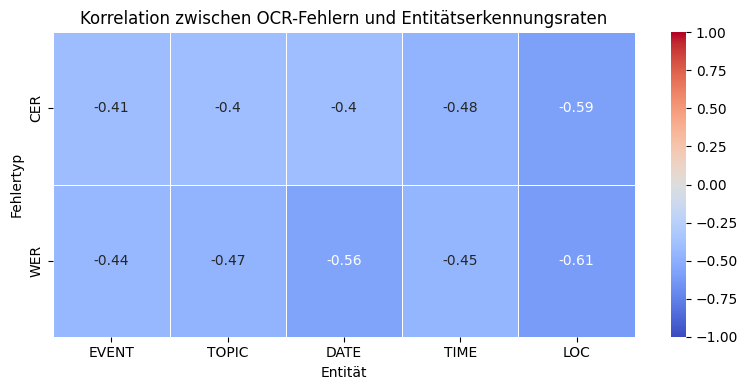

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Korrelationen wie gehabt
korrelationen = pd.DataFrame({
    'CER': {
        'EVENT': -0.412744,
        'TOPIC': -0.400235,
        'DATE': -0.400235,
        'TIME': -0.475891,
        'LOC': -0.593467
    },
    'WER': {
        'EVENT': -0.439414,
        'TOPIC': -0.473769,
        'DATE': -0.564583,
        'TIME': -0.454636,
        'LOC': -0.611269
    }
})

# Transponieren für Heatmap (damit CER/WER auf Y-Achse sind)
korrelationen = korrelationen.T

# Heatmap plotten
plt.figure(figsize=(8, 4))
sns.heatmap(korrelationen, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Korrelation zwischen OCR-Fehlern und Entitätserkennungsraten')
plt.xlabel('Entität')
plt.ylabel('Fehlertyp')
plt.tight_layout()
plt.show()
